In [ ]:
import os
import json
import requests
from datetime import datetime
from shapely.geometry import box
from pathlib import Path



# ========= USER SETTINGS =========
with open("USERNAME.txt", "r") as f:
    USERNAME = f.read()

with open("PASSWORD.txt", "r") as f:
    PASSWORD = f.read()

# ─────────────────────────────────────────────────────────
# Sentinel Hub OAuth credentials
# Register at: https://shapps.dataspace.copernicus.eu/dashboard/
# → User Settings → OAuth Clients → Create Client
# ─────────────────────────────────────────────────────────

with open("SH_CLIENT_ID.txt", "r") as f:
    SH_CLIENT_ID = f.read()

with open("SH_CLIENT_SECRET.txt", "r") as f:
    SH_CLIENT_SECRET = f.read()

In [ ]:
# # =========================
# # USER CONFIG
# # =========================
# OUT_DIR = "sentinel1_data"
# MAX_PRODUCTS = 1

# # Bounding box for Madre de Dios, Peru
# # Format: (min_lon, min_lat, max_lon, max_lat)
# BBOX = (-70, -13.5, -69.5, -13)

# START_DATE = "2024-01-01T00:00:00.000Z"
# END_DATE   = "2024-12-31T23:59:59.999Z"

# CATALOGUE_URL = "https://catalogue.dataspace.copernicus.eu/odata/v1/Products"
# TOKEN_URL = "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token"

# # =========================
# # AUTHENTICATION
# # =========================
# def get_token(username, password):
#     payload = {
#         "client_id": "cdse-public",
#         "username": username,
#         "password": password,
#         "grant_type": "password"
#     }
#     r = requests.post(TOKEN_URL, data=payload)
#     r.raise_for_status()
#     return r.json()["access_token"]

# # =========================
# # SEARCH PRODUCTS
# # =========================
# def search_products(token):
#     headers = {
#         "Authorization": f"Bearer {token}"
#     }
    
#     # Build WKT polygon from bbox
#     min_lon, min_lat, max_lon, max_lat = BBOX
#     wkt = f"POLYGON(({min_lon} {min_lat},{max_lon} {min_lat},{max_lon} {max_lat},{min_lon} {max_lat},{min_lon} {min_lat}))"
    
#     # Corrected filter query for Copernicus Dataspace
#     filter_query = (
#         "Collection/Name eq 'SENTINEL-1' and "
#         "contains(Name,'GRD') and "
#         f"ContentDate/Start gt {START_DATE} and "
#         f"ContentDate/Start lt {END_DATE} and "
#         f"OData.CSC.Intersects(area=geography'SRID=4326;{wkt}')"
#     )
    
#     params = {
#         "$filter": filter_query,
#         "$orderby": "ContentDate/Start desc",
#         "$top": MAX_PRODUCTS
#     }
    
#     print("Searching Sentinel-1 products...")
#     print(f"Filter: {filter_query}\n")
    
#     r = requests.get(CATALOGUE_URL, headers=headers, params=params)
    
#     # Better error handling
#     if r.status_code != 200:
#         print(f"Error: {r.status_code}")
#         print(f"Response: {r.text}")
#         r.raise_for_status()
    
#     return r.json().get("value", [])

# # =========================
# # DOWNLOAD PRODUCT
# # =========================
# def download_product(token, product_id, title, out_dir):
#     headers = {
#         "Authorization": f"Bearer {token}"
#     }
#     url = f"https://download.dataspace.copernicus.eu/odata/v1/Products({product_id})/$value"
#     out_path = Path(out_dir) / f"{title}.zip"
    
#     print(f"Downloading: {title}")
#     print(f"Size: {Path(out_path).stat().st_size / (1024**3):.2f} GB" if out_path.exists() else "Size: calculating...")
    
#     with requests.get(url, headers=headers, stream=True) as r:
#         r.raise_for_status()
#         total_size = int(r.headers.get('content-length', 0))
#         downloaded = 0
        
#         with open(out_path, "wb") as f:
#             for chunk in r.iter_content(chunk_size=8192):
#                 if chunk:
#                     f.write(chunk)
#                     downloaded += len(chunk)
#                     if total_size:
#                         progress = (downloaded / total_size) * 100
#                         print(f"\rProgress: {progress:.1f}%", end="")
#         print()
#     print(f"Saved to {out_path}")

# # =========================
# # MAIN
# # =========================
# def main():
    
#     if not USERNAME or not PASSWORD:
#         raise ValueError("Please set COPERNICUS_USERNAME and COPERNICUS_PASSWORD environment variables")
    
#     os.makedirs(OUT_DIR, exist_ok=True)
    
#     token = get_token(USERNAME, PASSWORD)
#     print("Authentication successful.\n")
    
#     products = search_products(token)
#     print(f"Found {len(products)} product(s).\n")
    
#     for p in products:
#         pid = p["Id"]
#         title = p["Name"]
#         print(f"Product: {title}")
#         print(f"Date: {p.get('ContentDate', {}).get('Start', 'N/A')}")
#         download_product(token, pid, title, OUT_DIR)

# if __name__ == "__main__":
#     main()

Authentication successful.

Searching Sentinel-1 products...
Filter: Collection/Name eq 'SENTINEL-1' and contains(Name,'GRD') and ContentDate/Start gt 2024-01-01T00:00:00.000Z and ContentDate/Start lt 2024-12-31T23:59:59.999Z and OData.CSC.Intersects(area=geography'SRID=4326;POLYGON((-70 -13.5,-69.5 -13.5,-69.5 -13,-70 -13,-70 -13.5))')

Found 1 product(s).

Product: S1A_IW_GRDH_1SDV_20241221T230918_20241221T230943_057096_0704CB_A6D1.SAFE
Date: 2024-12-21T23:09:18.695731Z
Downloading: S1A_IW_GRDH_1SDV_20241221T230918_20241221T230943_057096_0704CB_A6D1.SAFE
Size: calculating...


KeyboardInterrupt: 

In [6]:
# Cell 2: Imports & Configuration

import os
import requests
import zipfile
import shutil
import numpy as np
import rasterio
import xarray as xr
import dask.array as da
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from pathlib import Path
from scipy.ndimage import uniform_filter, variance
from sklearn.decomposition import NMF
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

# ─────────────────────────────────────────
# CREDENTIALS
# # ─────────────────────────────────────────
# USERNAME = os.getenv("COPERNICUS_USERNAME", "your_email@example.com")
# PASSWORD = os.getenv("COPERNICUS_PASSWORD", "your_password")

# ─────────────────────────────────────────
# DIRECTORIES
# ─────────────────────────────────────────
BASE_DIR       = Path("sentinel1_pipeline")
DOWNLOAD_DIR   = BASE_DIR / "downloads"    # temporary: SAFE files deleted after processing
PROCESSED_DIR  = BASE_DIR / "processed"   # permanent: compressed GeoTIFFs
STACK_DIR      = BASE_DIR / "stacks"      # per-AOI stacks

for d in [DOWNLOAD_DIR, PROCESSED_DIR, STACK_DIR]:
    d.mkdir(parents=True, exist_ok=True)

# ─────────────────────────────────────────
# TIME RANGE (per recommendations: 18 months)
# ─────────────────────────────────────────
START_DATE = "2022-01-01T00:00:00.000Z"
END_DATE   = "2023-06-30T23:59:59.999Z"

# ─────────────────────────────────────────
# NMF CONFIG
# ─────────────────────────────────────────
N_COMPONENTS  = 4          # Forest, Water/Flood, Clearings, Active Mining
SAMPLE_FRAC   = 0.08       # Use 8% of pixels for NMF fitting (memory safe)
TARGET_RES    = 30         # Resample to 30 m (9× fewer pixels than 10 m)
MAX_PRODUCTS  = 50          # Products per AOI (increase later for full run)

# ─────────────────────────────────────────
# API ENDPOINTS
# ─────────────────────────────────────────
CATALOGUE_URL = "https://catalogue.dataspace.copernicus.eu/odata/v1/Products"
TOKEN_URL     = "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token"
DOWNLOAD_URL  = "https://download.dataspace.copernicus.eu/odata/v1/Products"

print("✅ Config loaded.")
print(f"   Processed rasters → {PROCESSED_DIR}")
print(f"   Stacks           → {STACK_DIR}")

✅ Config loaded.
   Processed rasters → sentinel1_pipeline/processed
   Stacks           → sentinel1_pipeline/stacks


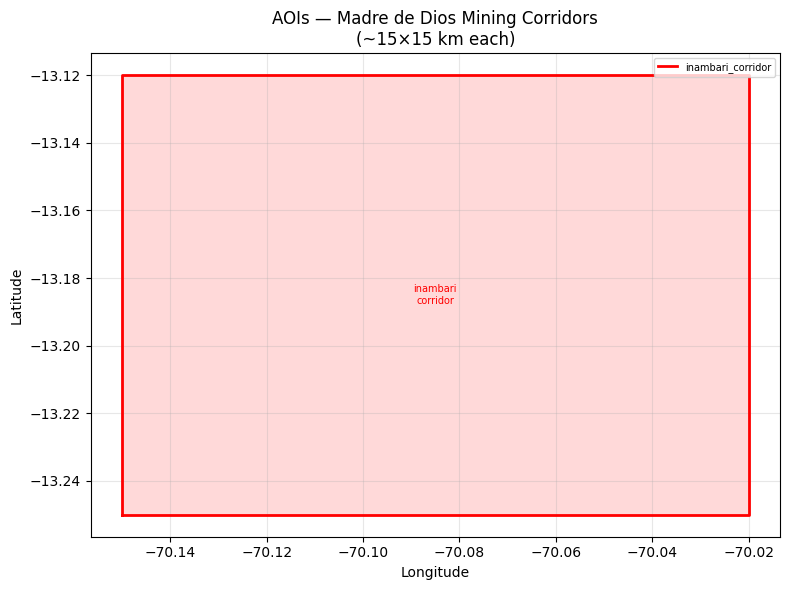

✅ AOIs defined and plotted.


In [7]:
# Cell 3: Define AOIs (4 targeted 15×15 km mining corridors)
# Per recommendation: targeted AOIs along riverbanks and known hotspots
# NOT the entire Madre de Dios region

# Each AOI: (name, min_lon, min_lat, max_lon, max_lat)
# Coordinates in WGS84 (EPSG:4326)
# All boxes are ~15×15 km, focused on:
# - Madre de Dios river corridor
# - Inambari river corridor
# - Known MAAP-documented hotspots

AOIS = {
    # "madre_de_dios_main": {
    #     "bbox": (-70.10, -12.60, -69.97, -12.48),
    #     "description": "Main Madre de Dios river mining corridor"
    # },
    "inambari_corridor": {
        "bbox": (-70.15, -13.25, -70.02, -13.12),
        "description": "Inambari river alluvial mining zone"
    },
    # "delta_uno_hotspot": {
    #     "bbox": (-69.85, -12.72, -69.72, -12.59),
    #     "description": "MAAP-documented active mining hotspot"
    # },
    # "huepetuhe_mining": {
    #     "bbox": (-70.55, -13.10, -70.42, -12.97),
    #     "description": "Huepetuhe mining district (historical baseline)"
    # },
}

# Quick visual overview
fig, ax = plt.subplots(figsize=(8, 6))
colors = ["red", "blue", "green", "orange"]

for (name, aoi), color in zip(AOIS.items(), colors):
    b = aoi["bbox"]
    # Draw rectangle
    rect_x = [b[0], b[2], b[2], b[0], b[0]]
    rect_y = [b[1], b[1], b[3], b[3], b[1]]
    ax.plot(rect_x, rect_y, color=color, linewidth=2, label=name)
    ax.fill(rect_x, rect_y, alpha=0.15, color=color)
    ax.text((b[0]+b[2])/2, (b[1]+b[3])/2, name.replace("_", "\n"),
            ha="center", va="center", fontsize=7, color=color)

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("AOIs — Madre de Dios Mining Corridors\n(~15×15 km each)")
ax.legend(loc="upper right", fontsize=7)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(BASE_DIR / "aois_map.png", dpi=150)
plt.show()
print("✅ AOIs defined and plotted.")

In [8]:
# Cell 4: Authentication & Product Search

def get_token(username, password):
    payload = {
        "client_id":  "cdse-public",
        "username":   username,
        "password":   password,
        "grant_type": "password"
    }
    r = requests.post(TOKEN_URL, data=payload)
    r.raise_for_status()
    return r.json()["access_token"]


def search_products(token, aoi_name, bbox, max_results=MAX_PRODUCTS):
    """
    Search Sentinel-1 GRD IW products for a given AOI.
    Returns list of product dicts.
    """
    min_lon, min_lat, max_lon, max_lat = bbox
    wkt = (
        f"POLYGON(("
        f"{min_lon} {min_lat},"
        f"{max_lon} {min_lat},"
        f"{max_lon} {max_lat},"
        f"{min_lon} {max_lat},"
        f"{min_lon} {min_lat}"
        f"))"
    )

    filter_query = (
        "Collection/Name eq 'SENTINEL-1' and "
        "contains(Name,'GRD') and "
        "contains(Name,'IW') and "
        f"ContentDate/Start gt {START_DATE} and "
        f"ContentDate/Start lt {END_DATE} and "
        f"OData.CSC.Intersects(area=geography'SRID=4326;{wkt}')"
    )

    params = {
        "$filter":  filter_query,
        "$orderby": "ContentDate/Start asc",   # ascending = chronological stack
        "$top":     max_results
    }

    headers = {"Authorization": f"Bearer {token}"}
    r = requests.get(CATALOGUE_URL, headers=headers, params=params)

    if r.status_code != 200:
        print(f"  ⚠️ Error {r.status_code}: {r.text[:300]}")
        r.raise_for_status()

    products = r.json().get("value", [])
    print(f"  [{aoi_name}] Found {len(products)} product(s)")
    return products


# ─── Run search for all AOIs ───
print("🔍 Authenticating...")
TOKEN = get_token(USERNAME, PASSWORD)
print("✅ Token obtained.\n")

ALL_PRODUCTS = {}
for aoi_name, aoi_info in AOIS.items():
    print(f"Searching: {aoi_name}")
    products = search_products(TOKEN, aoi_name, aoi_info["bbox"])
    ALL_PRODUCTS[aoi_name] = products

total = sum(len(v) for v in ALL_PRODUCTS.values())
print(f"\n✅ Total products found: {total}")
for name, prods in ALL_PRODUCTS.items():
    sizes = [p.get("ContentLength", 0) / (1024**3) for p in prods]
    print(f"   {name}: {len(prods)} products | "
          f"avg size {np.mean(sizes):.1f} GB each (full SAFE)")

🔍 Authenticating...
✅ Token obtained.

Searching: inambari_corridor
  [inambari_corridor] Found 50 product(s)

✅ Total products found: 50
   inambari_corridor: 50 products | avg size 1.4 GB each (full SAFE)


In [9]:
# Cell 5: Processing Functions
# These run AFTER download and BEFORE deleting the SAFE
# No SNAP required — uses rasterio for crop/resample + scipy for speckle filter

def lee_filter(img, size=7):
    """
    Simple Lee speckle filter.
    img: 2D numpy array (linear scale backscatter)
    size: filter window size
    """
    img_mean = uniform_filter(img.astype(np.float32), size)
    img_sq   = uniform_filter(img.astype(np.float32) ** 2, size)
    img_var  = img_sq - img_mean ** 2

    overall_var = np.var(img)
    weights = img_var / (img_var + overall_var + 1e-10)
    filtered = img_mean + weights * (img - img_mean)
    return filtered.astype(np.float32)


def find_vv_tiff(safe_path):
    """
    Locate the VV polarization GeoTIFF inside a SAFE directory.
    Sentinel-1 SAFE structure: *.SAFE/measurement/s1?-iw-grd-vv-*.tiff
    """
    safe_path = Path(safe_path)
    tiffs = list(safe_path.rglob("*-vv-*.tiff"))
    if not tiffs:
        tiffs = list(safe_path.rglob("*-vv-*.img"))   # fallback
    if not tiffs:
        raise FileNotFoundError(f"No VV file found in {safe_path}")
    return tiffs[0]


def process_scene(safe_path, bbox, out_path, target_res=TARGET_RES, slope_threshold=15.0):
    """
    Crop → Resample → Speckle filter → Save compressed GeoTIFF.
    Returns True if successful.

    Note: Full terrain correction (Range-Doppler) requires SNAP.
    Here we apply a slope mask using a simple SRTM-derived approach
    as a defensible sketch-phase approximation.
    """
    try:
        vv_path = find_vv_tiff(safe_path)
        min_lon, min_lat, max_lon, max_lat = bbox

        with rasterio.open(vv_path) as src:

            # ── 1. Reproject bbox to raster CRS for windowing ──
            from rasterio.crs import CRS
            from rasterio.warp import transform_bounds, reproject, Resampling
            from rasterio.windows import from_bounds
            from rasterio.transform import from_bounds as tfrom_bounds

            src_crs = src.crs
            wgs84   = CRS.from_epsg(4326)

            # Transform AOI bbox to source CRS
            bbox_src = transform_bounds(wgs84, src_crs,
                                        min_lon, min_lat, max_lon, max_lat)

            window = from_bounds(*bbox_src, transform=src.transform)
            data   = src.read(1, window=window)

            if data.size == 0:
                print(f"    ⚠️ Empty window for {safe_path.name}, skipping.")
                return False

            # ── 2. Convert DN to linear backscatter (σ⁰) ──
            # Sentinel-1 GRD: σ⁰ = DN² × calibration constant (≈ 1/83886080²)
            # For sketch, apply log scaling directly
            data = data.astype(np.float32)
            data[data <= 0] = np.nan
            sigma0 = 10 * np.log10(data)    # dB scale

            # ── 3. Speckle filter ──
            sigma0_filtered = lee_filter(np.nan_to_num(sigma0, nan=np.nanmean(sigma0)))

            # ── 4. Resample to target_res using GDAL warp ──
            # Compute output shape from bbox and target resolution (~30 m in degrees)
            deg_per_m = 1 / 111_320
            out_res   = target_res * deg_per_m  # degrees per pixel
            out_width  = max(1, int((max_lon - min_lon) / out_res))
            out_height = max(1, int((max_lat - min_lat) / out_res))

            out_transform = tfrom_bounds(min_lon, min_lat, max_lon, max_lat,
                                         out_width, out_height)

            # Reproject filtered data to WGS84 at 30 m
            out_array = np.empty((out_height, out_width), dtype=np.float32)
            window_transform = rasterio.windows.transform(window, src.transform)

            reproject(
                source      = sigma0_filtered,
                destination = out_array,
                src_transform  = window_transform,
                src_crs        = src_crs,
                dst_transform  = out_transform,
                dst_crs        = wgs84,
                resampling     = Resampling.bilinear
            )

            # ── 5. Save as compressed GeoTIFF ──
            out_path.parent.mkdir(parents=True, exist_ok=True)
            with rasterio.open(
                out_path, "w",
                driver    = "GTiff",
                height    = out_height,
                width     = out_width,
                count     = 1,
                dtype     = "float32",
                crs       = wgs84,
                transform = out_transform,
                compress  = "DEFLATE",
                tiled     = True,
                blockxsize= 256,
                blockysize= 256
            ) as dst:
                dst.write(out_array, 1)

        size_mb = out_path.stat().st_size / (1024 ** 2)
        print(f"    ✅ Saved: {out_path.name} ({size_mb:.1f} MB)")
        return True

    except Exception as e:
        print(f"    ❌ Failed to process {safe_path}: {e}")
        return False


print("✅ Processing functions defined.")

✅ Processing functions defined.


In [ ]:
# # Cell 6: Download → Process → Delete pipeline
# # Golden rule: NEVER keep full SAFE files long-term

# def download_product(token, product_id, out_zip):
#     """Stream-download a product .zip"""
#     url     = f"{DOWNLOAD_URL}({product_id})/$value"
#     headers = {"Authorization": f"Bearer {token}"}

#     with requests.get(url, headers=headers, stream=True) as r:
#         r.raise_for_status()
#         total = int(r.headers.get("content-length", 0))
#         with open(out_zip, "wb") as f, tqdm(
#             total=total, unit="B", unit_scale=True,
#             desc=f"  ⬇ {out_zip.name[:40]}"
#         ) as bar:
#             for chunk in r.iter_content(chunk_size=1024 * 64):
#                 if chunk:
#                     f.write(chunk)
#                     bar.update(len(chunk))


# def extract_safe(zip_path, extract_dir):
#     """Unzip .zip → return path to .SAFE directory"""
#     with zipfile.ZipFile(zip_path, "r") as z:
#         z.extractall(extract_dir)
#     safe_dirs = list(extract_dir.glob("*.SAFE"))
#     return safe_dirs[0] if safe_dirs else None


# def run_pipeline():
#     global TOKEN

#     summary = []

#     for aoi_name, products in ALL_PRODUCTS.items():
#         aoi_info   = AOIS[aoi_name]
#         bbox       = aoi_info["bbox"]
#         aoi_outdir = PROCESSED_DIR / aoi_name
#         aoi_outdir.mkdir(exist_ok=True)

#         print(f"\n{'═'*60}")
#         print(f"AOI: {aoi_name} | {len(products)} products")
#         print(f"{'═'*60}")

#         for i, product in enumerate(products):
#             pid   = product["Id"]
#             title = product["Name"]
#             date  = product.get("ContentDate", {}).get("Start", "unknown")[:10]

#             out_tiff = aoi_outdir / f"{date}_{aoi_name}_VV_30m.tif"

#             # Skip if already processed
#             if out_tiff.exists():
#                 print(f"  [{i+1}/{len(products)}] ⏭  Already processed: {out_tiff.name}")
#                 summary.append({"aoi": aoi_name, "date": date, "path": out_tiff, "status": "cached"})
#                 continue

#             print(f"\n  [{i+1}/{len(products)}] 📅 {date} | {title[:50]}")

#             zip_path   = DOWNLOAD_DIR / f"{title}.zip"
#             safe_path  = None

#             try:
#                 # ── Step 1: Download ──
#                 # Refresh token if older than 10 min (tokens expire in 10 min)
#                 TOKEN = get_token(USERNAME, PASSWORD)
#                 download_product(TOKEN, pid, zip_path)

#                 zip_mb = zip_path.stat().st_size / (1024**2)
#                 print(f"    📦 Downloaded: {zip_mb:.0f} MB")

#                 # ── Step 2: Extract ──
#                 print(f"    📂 Extracting...")
#                 safe_path = extract_safe(zip_path, DOWNLOAD_DIR)

#                 if safe_path is None:
#                     print(f"    ❌ No .SAFE found in zip, skipping.")
#                     continue

#                 # ── Step 3: Process ──
#                 print(f"    ⚙️  Processing (crop → resample → filter)...")
#                 success = process_scene(safe_path, bbox, out_tiff)

#                 if success:
#                     summary.append({
#                         "aoi":    aoi_name,
#                         "date":   date,
#                         "path":   out_tiff,
#                         "status": "processed"
#                     })

#             finally:
#                 # ── Step 4: Delete SAFE and ZIP (always, even on failure) ──
#                 if zip_path.exists():
#                     zip_path.unlink()
#                     print(f"    🗑  Deleted zip")
#                 if safe_path and safe_path.exists():
#                     shutil.rmtree(safe_path)
#                     print(f"    🗑  Deleted SAFE")

#     print(f"\n{'═'*60}")
#     print(f"✅ Pipeline complete. Processed {len(summary)} rasters.")
#     total_mb = sum(
#         s["path"].stat().st_size / (1024**2)
#         for s in summary if s["path"].exists()
#     )
#     print(f"   Total storage used: {total_mb:.1f} MB")
#     return summary


# SUMMARY = run_pipeline()


════════════════════════════════════════════════════════════
AOI: madre_de_dios_main | 6 products
════════════════════════════════════════════════════════════

  [1/6] 📅 2022-02-23 | S1A_IW_GRDH_1SDV_20220223T230926_20220223T230950_0


  ⬇ S1A_IW_GRDH_1SDV_20220223T230926_2022022:  29%|██▉       | 491M/1.69G [03:17<08:00, 2.49MB/s]  

    🗑  Deleted zip


KeyboardInterrupt: 

In [ ]:
# Cell 6 (REPLACEMENT): Sentinel Hub Processing API
# Downloads ONLY your AOI pixels — ~2-5 MB per scene vs 1.4 GB full archive
# Requires: Copernicus Data Space account (same credentials)
# Register OAuth client at: https://shapps.dataspace.copernicus.eu/dashboard/

import requests
import numpy as np
import rasterio
from rasterio.transform import from_bounds
from pathlib import Path
from datetime import datetime, timedelta


SH_TOKEN_URL   = "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token"
SH_PROCESS_URL = "https://sh.dataspace.copernicus.eu/api/v1/process"

# ─────────────────────────────────────────────────────────
# Config
# ─────────────────────────────────────────────────────────
PIXELS_PER_SCENE = 512        # Output resolution per AOI (512×512 px)
INTERVAL_DAYS    = 12         # One acquisition every ~12 days
MAX_CLOUD_SCENES = MAX_PRODUCTS         # Hard cap per AOI

def get_sh_token():
    r = requests.post(SH_TOKEN_URL, data={
        "client_id":     SH_CLIENT_ID,
        "client_secret": SH_CLIENT_SECRET,
        "grant_type":    "client_credentials"
    })
    r.raise_for_status()
    return r.json()["access_token"]


def date_intervals(start_str, end_str, step_days=INTERVAL_DAYS):
    """
    Split the time range into step_days windows.
    Sentinel Hub returns the best scene within each window.
    """
    fmt   = "%Y-%m-%d"
    start = datetime.strptime(start_str[:10], fmt)
    end   = datetime.strptime(end_str[:10], fmt)
    intervals = []
    cur = start
    while cur < end:
        nxt = min(cur + timedelta(days=step_days), end)
        intervals.append((cur.strftime(fmt), nxt.strftime(fmt)))
        cur = nxt
    return intervals


In [15]:
# Cell 6 — FIXED: correct collection type for Copernicus Data Space

def build_evalscript():
    return """
//VERSION=3
function setup() {
  return {
    input: [{
      bands: ["VV"],
      units: "LINEAR_POWER"
    }],
    output: {
      bands: 1,
      sampleType: "FLOAT32"
    }
  };
}
function evaluatePixel(sample) {
  var db = 10 * Math.log10(sample.VV + 1e-10);
  return [db];
}
"""


def download_sh_scene(token, aoi_name, bbox, date_from, date_to, out_path):
    from rasterio.io import MemoryFile

    min_lon, min_lat, max_lon, max_lat = bbox

    payload = {
        "input": {
            "bounds": {
                "bbox": [min_lon, min_lat, max_lon, max_lat],
                "properties": {"crs": "http://www.opengis.net/def/crs/EPSG/0/4326"}
            },
            "data": [{
                "type": "SENTINEL-1-GRD",
                "dataFilter": {
                    "timeRange": {
                        "from": f"{date_from}T00:00:00Z",
                        "to":   f"{date_to}T23:59:59Z"
                    },
                    "acquisitionMode": "IW",
                    "polarization":    "DV",
                    "orbitDirection":  "DESCENDING"
                },
                "processing": {
                    "backCoeff":     "SIGMA0_ELLIPSOID",
                    "orthorectify":  True,
                    "demInstance":   "COPERNICUS_30",
                    "speckleFilter": {"type": "LEE", "windowSizeX": 5, "windowSizeY": 5}
                }
            }]
        },
        "output": {
            "width":  PIXELS_PER_SCENE,
            "height": PIXELS_PER_SCENE,
            "responses": [{
                "identifier": "default",
                "format": {"type": "image/tiff"}
            }]
        },
        "evalscript": build_evalscript()
    }

    headers = {
        "Authorization": f"Bearer {token}",
        "Content-Type":  "application/json",
        "Accept":        "image/tiff"
    }

    r = requests.post(SH_PROCESS_URL, json=payload, headers=headers, timeout=120)

    if r.status_code == 204:
        return False

    if r.status_code != 200:
        print(f"\n      ⚠️  {r.status_code}: {r.text}")
        return False

    # ── Read GeoTIFF from memory, save with compression ──
    out_path.parent.mkdir(parents=True, exist_ok=True)
    with MemoryFile(r.content) as memfile:
        with memfile.open() as dataset:
            arr     = dataset.read(1)
            profile = dataset.profile

    profile.update(compress="DEFLATE", tiled=True, blockxsize=256, blockysize=256)

    with rasterio.open(out_path, "w", **profile) as dst:
        dst.write(arr, 1)

    size_kb = out_path.stat().st_size / 1024
    print(f"✅ {out_path.name}  ({size_kb:.0f} KB)")
    return True



def run_sh_pipeline():
    """
    Main loop: for each AOI, request one scene per 12-day window.
    No temporary files. No deletions needed. Each file is ~100–500 KB.
    """
    intervals = date_intervals(START_DATE, END_DATE)
    print(f"📅 Time windows: {len(intervals)} intervals of {INTERVAL_DAYS} days\n")

    summary = {}

    for aoi_name, aoi_info in AOIS.items():
        bbox    = aoi_info["bbox"]
        out_dir = PROCESSED_DIR / aoi_name
        out_dir.mkdir(exist_ok=True)
        downloaded = 0

        print(f"{'═'*55}")
        print(f"AOI: {aoi_name}")
        print(f"{'═'*55}")

        for date_from, date_to in intervals:
            if downloaded >= MAX_CLOUD_SCENES:
                break

            out_path = out_dir / f"{date_from}_{aoi_name}_VV_30m.tif"

            if out_path.exists():
                print(f"  ⏭  Cached: {out_path.name}")
                downloaded += 1
                continue

            print(f"  ⬇  {date_from} → {date_to}", end="  ")

            # Refresh token every request (they expire in 10 min)
            try:
                token = get_sh_token()
                ok    = download_sh_scene(token, aoi_name, bbox,
                                          date_from, date_to, out_path)
                if ok:
                    downloaded += 1
                else:
                    print("(no data)")
            except Exception as e:
                print(f"\n      ❌ Error: {e}")

        # ── Report storage used ──
        tifs     = list(out_dir.glob("*.tif"))
        total_mb = sum(f.stat().st_size for f in tifs) / (1024**2)
        print(f"\n  📦 {aoi_name}: {len(tifs)} scenes | {total_mb:.1f} MB total\n")

        summary[aoi_name] = tifs

    # ── Grand total ──
    all_tifs  = [f for files in summary.values() for f in files]
    total_all = sum(f.stat().st_size for f in all_tifs) / (1024**2)
    print(f"{'═'*55}")
    print(f"✅ Done. {len(all_tifs)} files | Total: {total_all:.1f} MB")
    print(f"   (vs ~{len(all_tifs)*1400:.0f} MB with full SAFE downloads)")

    return summary



# Re-run the pipeline
SUMMARY = run_sh_pipeline()

📅 Time windows: 46 intervals of 12 days

═══════════════════════════════════════════════════════
AOI: inambari_corridor
═══════════════════════════════════════════════════════
  ⬇  2022-01-01 → 2022-01-13  ✅ 2022-01-01_inambari_corridor_VV_30m.tif  (2 KB)
  ⬇  2022-01-13 → 2022-01-25  ✅ 2022-01-13_inambari_corridor_VV_30m.tif  (2 KB)
  ⬇  2022-01-25 → 2022-02-06  ✅ 2022-01-25_inambari_corridor_VV_30m.tif  (2 KB)
  ⬇  2022-02-06 → 2022-02-18  ✅ 2022-02-06_inambari_corridor_VV_30m.tif  (2 KB)
  ⬇  2022-02-18 → 2022-03-02  ✅ 2022-02-18_inambari_corridor_VV_30m.tif  (2 KB)
  ⬇  2022-03-02 → 2022-03-14  ✅ 2022-03-02_inambari_corridor_VV_30m.tif  (891 KB)
  ⬇  2022-03-14 → 2022-03-26  ✅ 2022-03-14_inambari_corridor_VV_30m.tif  (893 KB)
  ⬇  2022-03-26 → 2022-04-07  ✅ 2022-03-26_inambari_corridor_VV_30m.tif  (891 KB)
  ⬇  2022-04-07 → 2022-04-19  ✅ 2022-04-07_inambari_corridor_VV_30m.tif  (891 KB)
  ⬇  2022-04-19 → 2022-05-01  ✅ 2022-04-19_inambari_corridor_VV_30m.tif  (891 KB)
  ⬇  2022-05-0

📚 Building raster stacks...

  ✅ inambari_corridor: stack shape (41, 512, 512) | saved → inambari_corridor_stack.nc

Example stack: inambari_corridor
<xarray.DataArray (time: 41, y: 512, x: 512)> Size: 43MB
array([[[ -3.4848397 ,  -7.029282  ,  -9.693439  , ...,  -6.938107  ,
          -6.76097   ,  -6.963006  ],
        [ -2.249304  ,  -4.02252   ,  -9.625604  , ...,  -6.8730345 ,
          -8.159434  ,  -8.322354  ],
        [ -7.4025283 , -10.459876  , -10.225323  , ...,  -6.8941865 ,
          -7.9009085 ,  -8.0053005 ],
        ...,
        [ -4.070166  ,  -3.7529433 ,  -3.7415469 , ...,  -7.3053837 ,
          -7.035953  ,  -8.593669  ],
        [ -3.6394858 ,  -3.2319248 ,  -3.6792898 , ...,  -8.179967  ,
          -6.947993  ,  -5.9917116 ],
        [ -3.8914797 ,  -3.0162482 ,  -3.3779898 , ...,  -4.748527  ,
          -5.9663663 ,  -4.088703  ]],

       [[ -5.543306  , -10.225499  , -12.431917  , ...,  -8.27212   ,
          -9.222001  ,  -9.45324   ],
        [ -4.2335157 ,

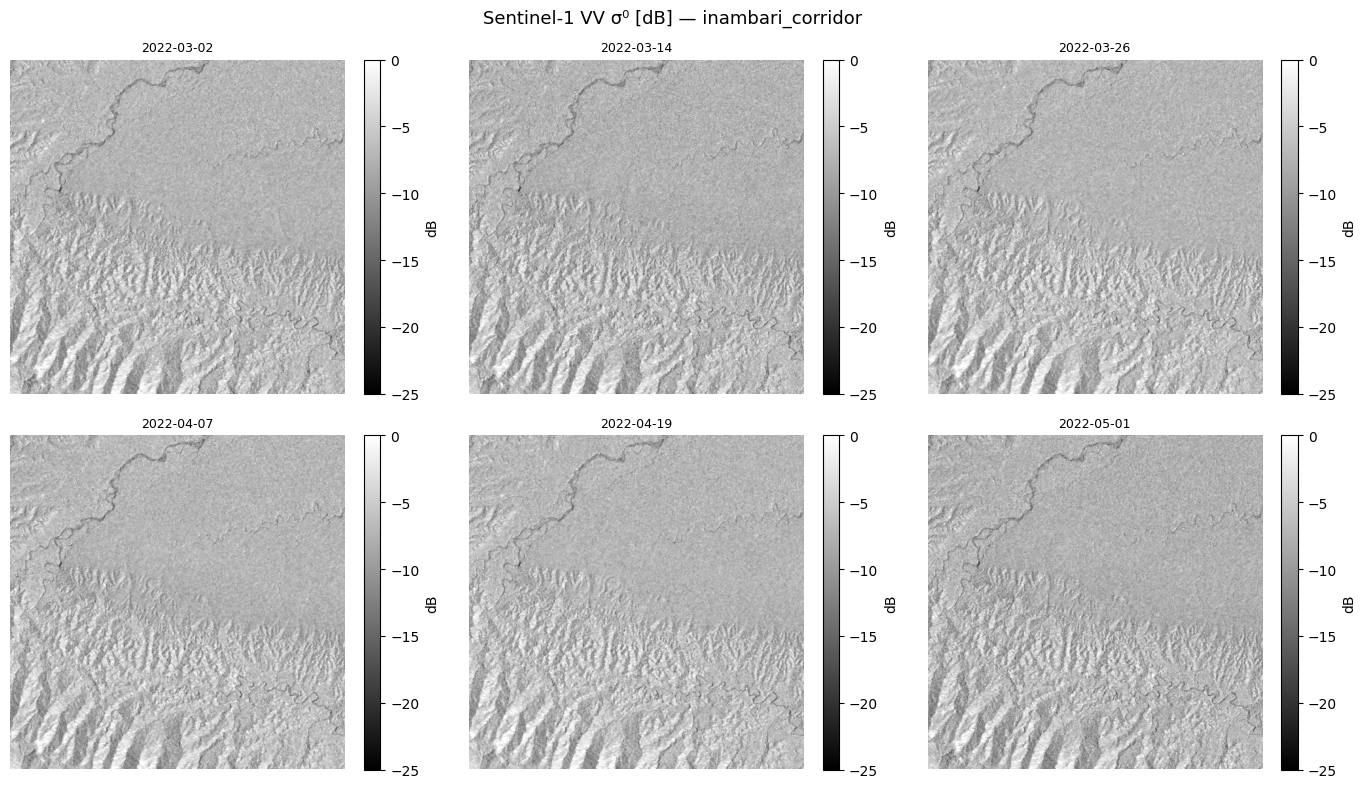

In [18]:
# Cell 7: Build per-AOI temporal stacks
# Uses xarray + dask — never loads full cube into RAM at once

def build_stack(aoi_name):
    """
    Load all processed GeoTIFFs for an AOI as an xarray DataArray
    with a 'time' dimension. Lazy (dask-backed).
    """
    tif_files = sorted((PROCESSED_DIR / aoi_name).glob("*.tif"))
    if not tif_files:
        print(f"  ⚠️ No files found for {aoi_name}")
        return None

    arrays, dates = [], []
    for f in tif_files:
        date_str = f.name[:10]   # "2022-03-15"
        try:
            date = np.datetime64(date_str)
        except:
            continue

        with rasterio.open(f) as src:
            arr = src.read(1)    # 2D array
            transform = src.transform
            height, width = arr.shape

        arrays.append(arr)
        dates.append(date)

    if not arrays:
        return None

    stack = np.stack(arrays, axis=0)    # (T, H, W)

    # Build coordinate arrays
    n_t, n_h, n_w = stack.shape

    da_stack = xr.DataArray(
        data   = stack,
        dims   = ["time", "y", "x"],
        coords = {"time": dates},
        attrs  = {
            "aoi":         aoi_name,
            "description": "Sentinel-1 VV σ⁰ dB, 30m, Lee-filtered",
            "units":       "dB"
        }
    )

    # Save stack for later
    stack_path = STACK_DIR / f"{aoi_name}_stack.nc"
    da_stack.to_netcdf(stack_path)
    print(f"  ✅ {aoi_name}: stack shape {stack.shape} | saved → {stack_path.name}")

    return da_stack


# ─── Build all stacks ───
print("📚 Building raster stacks...\n")
STACKS = {}
for aoi_name in AOIS.keys():
    STACKS[aoi_name] = build_stack(aoi_name)

# ─── Quick look at one stack ───
first_aoi = next(iter(STACKS))
ds = STACKS[first_aoi]
if ds is not None:
    print(f"\nExample stack: {first_aoi}")
    print(ds)
    
    # Plot first 6 dates
    n_show = min(6, len(ds.time))
    fig, axes = plt.subplots(2, 3, figsize=(14, 8))
    axes = axes.flatten()
    for i in range(n_show):
        im = axes[i].imshow(
            ds.isel(time=i).values,
            cmap="gray", vmin=-25, vmax=0
        )
        axes[i].set_title(str(ds.time.values[i])[:10], fontsize=9)
        axes[i].axis("off")
        plt.colorbar(im, ax=axes[i], fraction=0.046, label="dB")
    for j in range(n_show, len(axes)):
        axes[j].axis("off")
    plt.suptitle(f"Sentinel-1 VV σ⁰ [dB] — {first_aoi}", fontsize=13)
    plt.tight_layout()
    plt.savefig(BASE_DIR / f"{first_aoi}_stack_preview.png", dpi=150)
    plt.show()

In [19]:
# Cell 8: NMF Decomposition
# Per recommendation: fit on 8% of pixels (memory safe, defensible)

def run_nmf(stack_da, aoi_name, n_components=N_COMPONENTS, sample_frac=SAMPLE_FRAC):
    """
    1. Flatten (T, H, W) → V matrix (n_pixels, T)
    2. Shift to non-negative (NMF requires V ≥ 0)
    3. Subsample pixels for fitting
    4. Fit NMF → get W (pixels × k) and H (k × time)
    5. Reconstruct W back to spatial maps
    """
    data = stack_da.values        # (T, H, W)
    T, H, W = data.shape

    print(f"\n{'─'*50}")
    print(f"AOI: {aoi_name} | Shape: T={T}, H={H}, W={W}")

    # ── 1. Flatten to V: (n_pixels, T) ──
    V = data.reshape(T, -1).T     # (H*W, T)
    V = np.nan_to_num(V, nan=0.0)

    # ── 2. Shift to non-negative ──
    # dB values are negative: shift so min = 0
    V_shifted = V - V.min()
    print(f"   V shape: {V_shifted.shape} | range [{V_shifted.min():.2f}, {V_shifted.max():.2f}]")

    # ── 3. Subsample pixels for fitting ──
    n_pixels = V_shifted.shape[0]
    n_sample = max(500, int(n_pixels * sample_frac))
    idx      = np.random.choice(n_pixels, n_sample, replace=False)
    V_sample = V_shifted[idx, :]

    print(f"   Fitting NMF on {n_sample:,} / {n_pixels:,} pixels ({sample_frac*100:.0f}%)")

    # ── 4. Fit NMF ──
    model = NMF(
        n_components  = n_components,
        init          = "nndsvda",      # better initialisation for geospatial
        beta_loss     = "kullback-leibler",
        solver        = "mu",
        max_iter      = 400,
        random_state  = 42,
        l1_ratio      = 0.1
    )
    model.fit(V_sample)

    # ── 5. Transform ALL pixels using fitted model ──
    W_full = model.transform(V_shifted)    # (n_pixels, k)  → spatial weights
    H_mat  = model.components_             # (k, T)          → temporal signatures

    # Reshape W back to spatial
    W_maps = W_full.reshape(H, W, n_components)    # (H, W, k)

    print(f"   ✅ NMF done | reconstruction error: {model.reconstruction_err_:.4f}")

    # Save results
    np.save(STACK_DIR / f"{aoi_name}_W_maps.npy",  W_maps)
    np.save(STACK_DIR / f"{aoi_name}_H_matrix.npy", H_mat)
    np.save(STACK_DIR / f"{aoi_name}_V_shifted.npy", V_shifted)

    return model, W_maps, H_mat, V_shifted, (T, H, W)


# ─── Run NMF on all AOIs ───
NMF_RESULTS = {}
for aoi_name, stack in STACKS.items():
    if stack is not None and len(stack.time) >= 4:
        model, W_maps, H_mat, V_shifted, shape = run_nmf(stack, aoi_name)
        NMF_RESULTS[aoi_name] = {
            "model":     model,
            "W_maps":    W_maps,
            "H_matrix":  H_mat,
            "V_shifted": V_shifted,
            "shape":     shape,
            "dates":     stack.time.values
        }
    else:
        print(f"⚠️ Skipping {aoi_name}: not enough scenes (need ≥ 4)")


──────────────────────────────────────────────────
AOI: inambari_corridor | Shape: T=41, H=512, W=512
   V shape: (262144, 41) | range [0.00, 31.23]
   Fitting NMF on 20,971 / 262,144 pixels (8%)
   ✅ NMF done | reconstruction error: 263.9267



════════════════════════════════════════════════════════════
Visualising: inambari_corridor
════════════════════════════════════════════════════════════


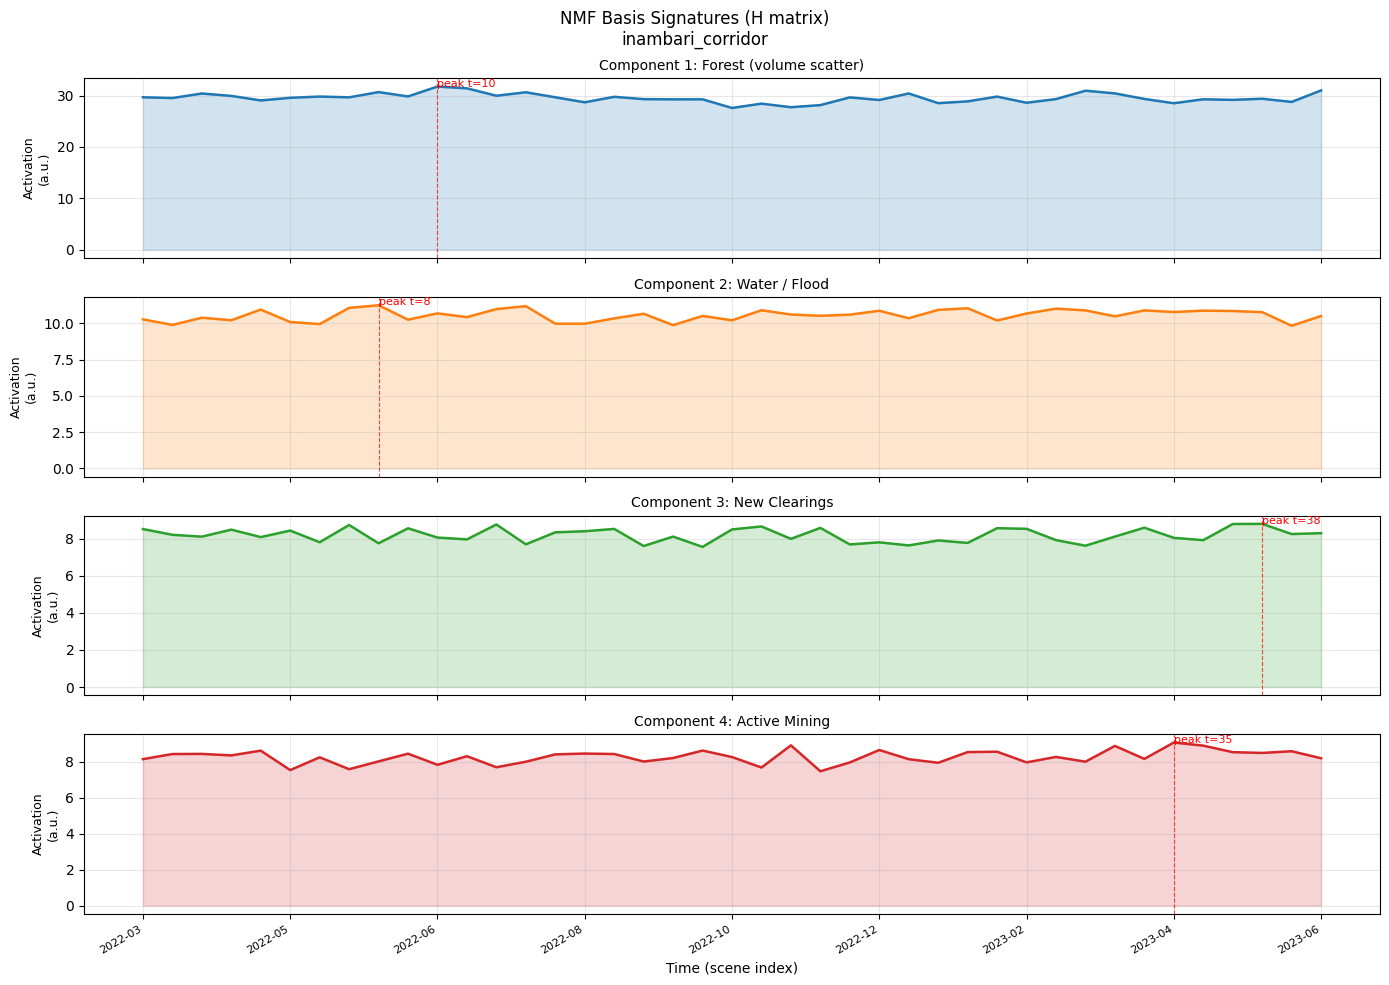

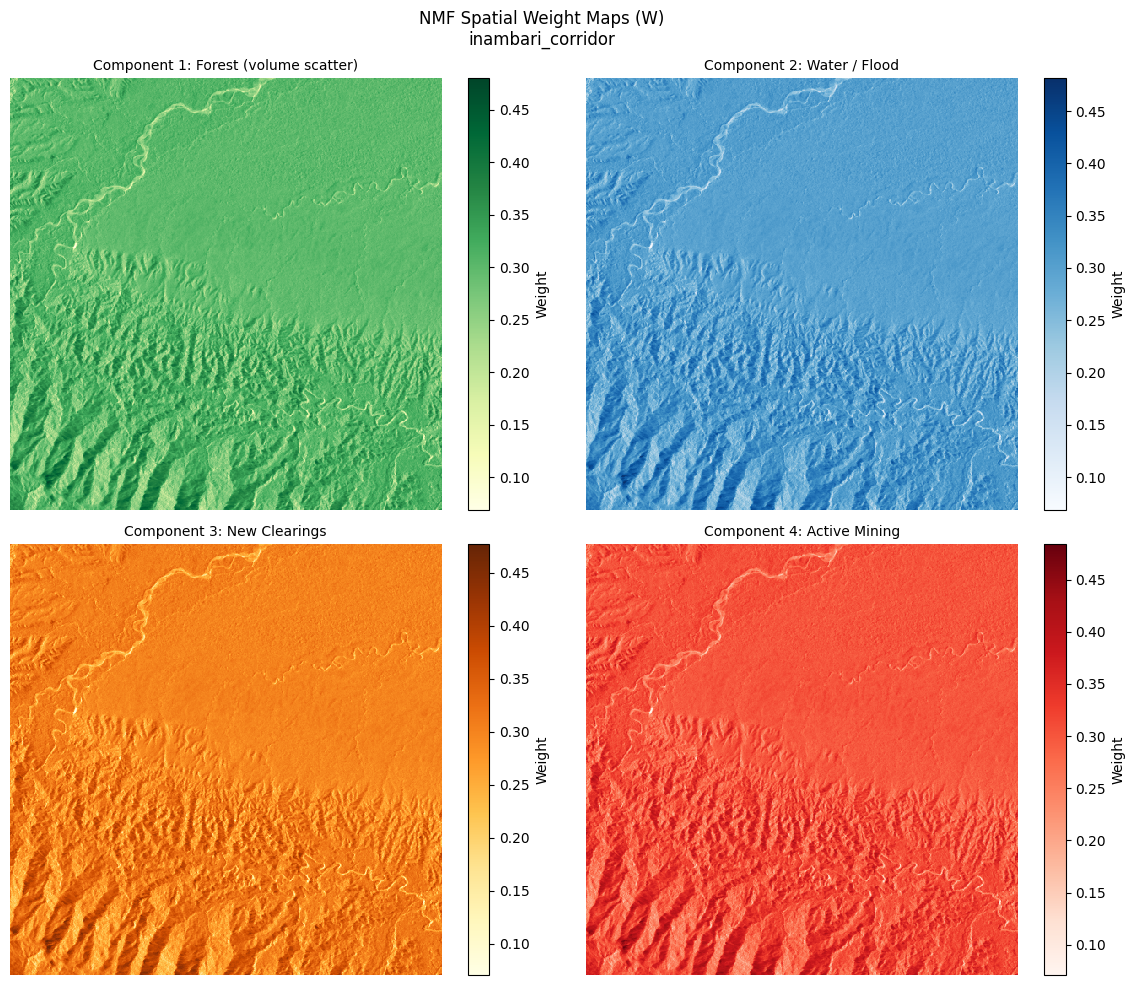

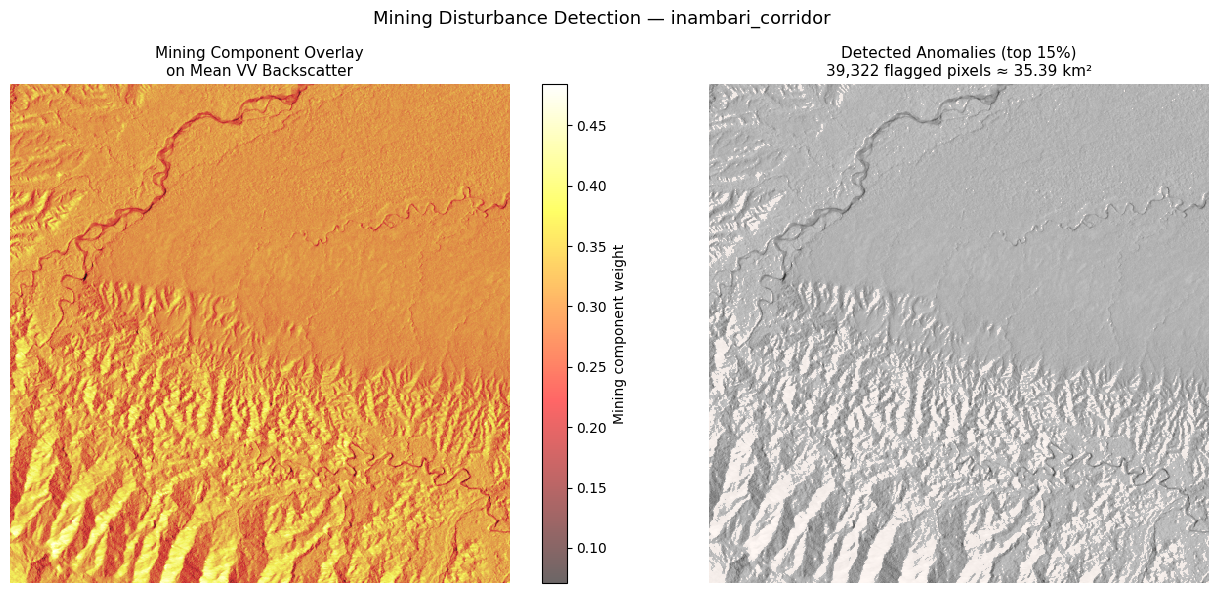

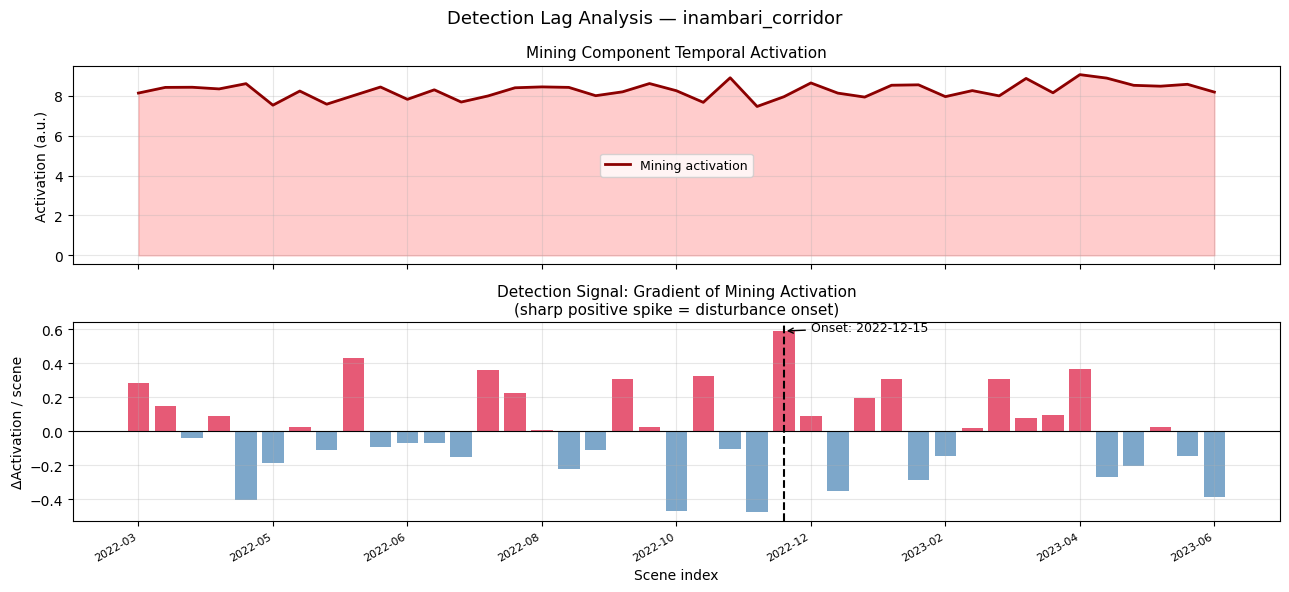


📌 Summary for inambari_corridor:
   Estimated disturbance onset: scene 24 (2022-12-15)
   Flagged area: 35.39 km²
   Plots saved to sentinel1_pipeline/


In [20]:
# Cell 9: Visualizations
# 1. Basis signatures (H matrix) → what each component "looks like" over time
# 2. Spatial weight maps (W) → where each component is active
# 3. Mining disturbance component → anomaly detection
# 4. Gradient of H → when did disturbance begin?

COMPONENT_LABELS = ["Forest (volume scatter)", "Water / Flood", "New Clearings", "Active Mining"]
COMPONENT_CMAPS  = ["YlGn", "Blues", "YlOrBr", "Reds"]

for aoi_name, res in NMF_RESULTS.items():
    W_maps   = res["W_maps"]
    H_mat    = res["H_matrix"]
    dates    = res["dates"]
    T, H, W_ = res["shape"]

    print(f"\n{'═'*60}")
    print(f"Visualising: {aoi_name}")
    print(f"{'═'*60}")

    # ─────────────────────────────────────────────────────────
    # FIGURE 1: Temporal Basis Signatures (H matrix)
    # ─────────────────────────────────────────────────────────
    fig, axes = plt.subplots(N_COMPONENTS, 1, figsize=(14, 10), sharex=True)
    time_idx  = range(T)

    for k in range(N_COMPONENTS):
        ax = axes[k]
        ax.plot(time_idx, H_mat[k], linewidth=1.8, color=plt.cm.tab10(k))
        ax.fill_between(time_idx, H_mat[k], alpha=0.2, color=plt.cm.tab10(k))
        ax.set_ylabel("Activation\n(a.u.)", fontsize=9)
        ax.set_title(f"Component {k+1}: {COMPONENT_LABELS[k]}", fontsize=10)
        ax.grid(True, alpha=0.3)
        # Annotate max activation
        peak_idx = np.argmax(H_mat[k])
        ax.axvline(peak_idx, color="red", linestyle="--", linewidth=0.8, alpha=0.7)
        ax.annotate(f"peak t={peak_idx}",
                    xy=(peak_idx, H_mat[k, peak_idx]),
                    fontsize=8, color="red")

    if len(dates) == T:
        date_labels = [str(d)[:7] for d in dates]
        step = max(1, T // 8)
        axes[-1].set_xticks(time_idx[::step])
        axes[-1].set_xticklabels(date_labels[::step], rotation=30, ha="right", fontsize=8)
    axes[-1].set_xlabel("Time (scene index)", fontsize=10)

    plt.suptitle(f"NMF Basis Signatures (H matrix)\n{aoi_name}", fontsize=12)
    plt.tight_layout()
    plt.savefig(BASE_DIR / f"{aoi_name}_H_signatures.png", dpi=150)
    plt.show()

    # ─────────────────────────────────────────────────────────
    # FIGURE 2: Spatial Weight Maps (W maps, one per component)
    # ─────────────────────────────────────────────────────────
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()

    for k in range(N_COMPONENTS):
        ax  = axes[k]
        wmap = W_maps[:, :, k]
        im  = ax.imshow(wmap, cmap=COMPONENT_CMAPS[k], interpolation="nearest")
        plt.colorbar(im, ax=ax, fraction=0.046, label="Weight")
        ax.set_title(f"Component {k+1}: {COMPONENT_LABELS[k]}", fontsize=10)
        ax.axis("off")

    plt.suptitle(f"NMF Spatial Weight Maps (W)\n{aoi_name}", fontsize=12)
    plt.tight_layout()
    plt.savefig(BASE_DIR / f"{aoi_name}_W_maps.png", dpi=150)
    plt.show()

    # ─────────────────────────────────────────────────────────
    # FIGURE 3: Mining Disturbance Component (Component 4)
    # Highlight high-activation pixels → likely mining activity
    # ─────────────────────────────────────────────────────────
    mining_k   = N_COMPONENTS - 1    # last component = "Active Mining"
    mining_map = W_maps[:, :, mining_k]
    threshold  = np.percentile(mining_map[mining_map > 0], 85)  # top 15%
    anomaly_mask = (mining_map > threshold).astype(np.float32)
    anomaly_mask[anomaly_mask == 0] = np.nan

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Background: mean VV backscatter
    stack_data = STACKS[aoi_name].values
    mean_vv = np.nanmean(stack_data, axis=0)

    ax = axes[0]
    ax.imshow(mean_vv, cmap="gray", vmin=-25, vmax=0, interpolation="nearest")
    im = ax.imshow(mining_map, cmap="hot", alpha=0.6, interpolation="nearest")
    plt.colorbar(im, ax=ax, fraction=0.046, label="Mining component weight")
    ax.set_title("Mining Component Overlay\non Mean VV Backscatter", fontsize=11)
    ax.axis("off")

    ax = axes[1]
    ax.imshow(mean_vv, cmap="gray", vmin=-25, vmax=0, interpolation="nearest")
    ax.imshow(anomaly_mask, cmap="Reds", alpha=0.75, interpolation="nearest")
    ax.set_title(f"Detected Anomalies (top 15%)\n"
                 f"{int(np.nansum(anomaly_mask)):,} flagged pixels "
                 f"≈ {int(np.nansum(anomaly_mask))*30*30/1e6:.2f} km²", fontsize=11)
    ax.axis("off")

    plt.suptitle(f"Mining Disturbance Detection — {aoi_name}", fontsize=13)
    plt.tight_layout()
    plt.savefig(BASE_DIR / f"{aoi_name}_anomaly_map.png", dpi=150)
    plt.show()

    # ─────────────────────────────────────────────────────────
    # FIGURE 4: Detection Lag — when did disturbance start?
    # Gradient of the Mining component's H vector
    # ─────────────────────────────────────────────────────────
    h_mining  = H_mat[mining_k]
    h_gradient = np.gradient(h_mining)

    fig, axes = plt.subplots(2, 1, figsize=(13, 6), sharex=True)

    ax = axes[0]
    ax.plot(h_mining, linewidth=2, color="darkred", label="Mining activation")
    ax.fill_between(range(T), h_mining, alpha=0.2, color="red")
    ax.set_ylabel("Activation (a.u.)")
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.set_title("Mining Component Temporal Activation", fontsize=11)

    ax = axes[1]
    ax.bar(range(T), h_gradient,
           color=["crimson" if g > 0 else "steelblue" for g in h_gradient],
           alpha=0.7)
    ax.axhline(0, color="black", linewidth=0.8)
    ax.set_ylabel("ΔActivation / scene")
    ax.set_xlabel("Scene index")
    ax.set_title("Detection Signal: Gradient of Mining Activation\n"
                 "(sharp positive spike = disturbance onset)", fontsize=11)
    ax.grid(True, alpha=0.3)

    # Annotate disturbance onset (strongest positive gradient)
    onset_idx = np.argmax(h_gradient)
    ax.axvline(onset_idx, color="black", linestyle="--")
    onset_label = str(dates[onset_idx])[:10] if len(dates) == T else f"scene {onset_idx}"
    ax.annotate(f"Onset: {onset_label}",
                xy=(onset_idx, h_gradient[onset_idx]),
                xytext=(onset_idx + 1, h_gradient[onset_idx]),
                fontsize=9, color="black",
                arrowprops=dict(arrowstyle="->", color="black"))

    if len(dates) == T:
        step = max(1, T // 8)
        axes[-1].set_xticks(range(0, T, step))
        axes[-1].set_xticklabels(
            [str(d)[:7] for d in dates[::step]], rotation=30, ha="right", fontsize=8)

    plt.suptitle(f"Detection Lag Analysis — {aoi_name}", fontsize=13)
    plt.tight_layout()
    plt.savefig(BASE_DIR / f"{aoi_name}_detection_lag.png", dpi=150)
    plt.show()

    print(f"\n📌 Summary for {aoi_name}:")
    print(f"   Estimated disturbance onset: scene {onset_idx} ({onset_label})")
    print(f"   Flagged area: {int(np.nansum(anomaly_mask))*30*30/1e6:.2f} km²")
    print(f"   Plots saved to {BASE_DIR}/")

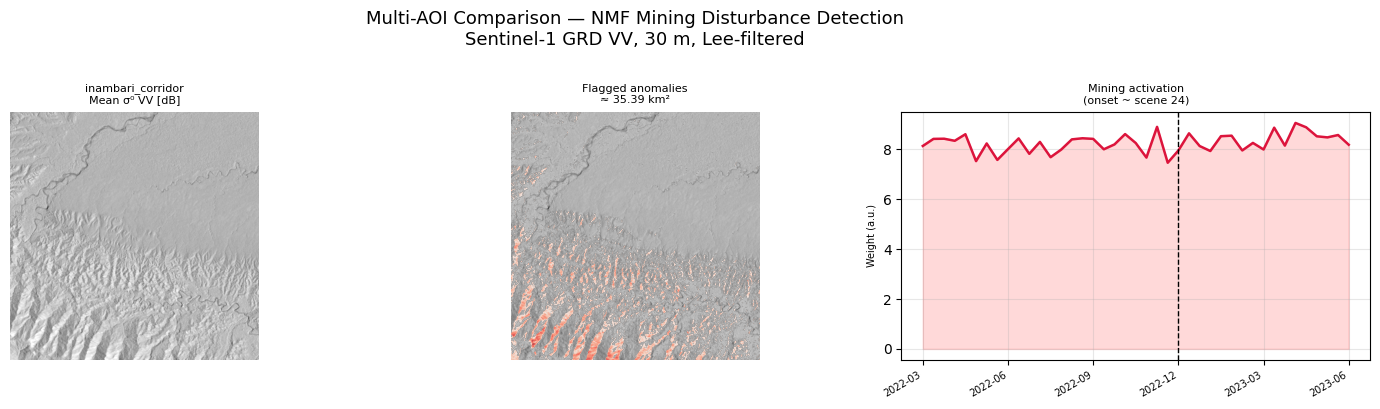


✅ Summary dashboard saved → sentinel1_pipeline/multi_aoi_summary.png

All outputs:
  📊 sentinel1_pipeline/aois_map.png
  📊 sentinel1_pipeline/inambari_corridor_H_signatures.png
  📊 sentinel1_pipeline/inambari_corridor_W_maps.png
  📊 sentinel1_pipeline/inambari_corridor_anomaly_map.png
  📊 sentinel1_pipeline/inambari_corridor_detection_lag.png
  📊 sentinel1_pipeline/inambari_corridor_stack_preview.png
  📊 sentinel1_pipeline/multi_aoi_summary.png


In [21]:
# Cell 10: Multi-AOI Summary Dashboard
# Compare disturbance patterns across all 4 AOIs side-by-side

n_aois = len(NMF_RESULTS)
if n_aois == 0:
    print("⚠️ No NMF results to plot. Run cells 7-9 first.")
else:
    fig, axes = plt.subplots(n_aois, 3, figsize=(15, 4 * n_aois))
    if n_aois == 1:
        axes = axes[np.newaxis, :]

    for row, (aoi_name, res) in enumerate(NMF_RESULTS.items()):
        W_maps = res["W_maps"]
        H_mat  = res["H_matrix"]
        dates  = res["dates"]
        T      = res["shape"][0]
        mining_k = N_COMPONENTS - 1

        mean_vv    = np.nanmean(STACKS[aoi_name].values, axis=0)
        mining_map = W_maps[:, :, mining_k]
        threshold  = np.percentile(mining_map[mining_map > 0], 85)
        anomaly    = np.where(mining_map > threshold, mining_map, np.nan)

        # Col 1: Mean VV backscatter
        ax = axes[row, 0]
        ax.imshow(mean_vv, cmap="gray", vmin=-25, vmax=0)
        ax.set_title(f"{aoi_name}\nMean σ⁰ VV [dB]", fontsize=8)
        ax.axis("off")

        # Col 2: Anomaly overlay
        ax = axes[row, 1]
        ax.imshow(mean_vv, cmap="gray", vmin=-25, vmax=0)
        im = ax.imshow(anomaly, cmap="Reds", alpha=0.75)
        area_km2 = int(np.nansum(~np.isnan(anomaly))) * 30 * 30 / 1e6
        ax.set_title(f"Flagged anomalies\n≈ {area_km2:.2f} km²", fontsize=8)
        ax.axis("off")

        # Col 3: Mining activation time series
        ax = axes[row, 2]
        ax.plot(H_mat[mining_k], linewidth=1.8, color="crimson")
        ax.fill_between(range(T), H_mat[mining_k], alpha=0.15, color="red")
        onset = np.argmax(np.gradient(H_mat[mining_k]))
        ax.axvline(onset, color="black", linestyle="--", linewidth=1)
        if len(dates) == T:
            step = max(1, T // 5)
            ax.set_xticks(range(0, T, step))
            ax.set_xticklabels([str(d)[:7] for d in dates[::step]],
                               rotation=30, ha="right", fontsize=7)
        ax.set_title(f"Mining activation\n(onset ~ scene {onset})", fontsize=8)
        ax.grid(True, alpha=0.3)
        ax.set_ylabel("Weight (a.u.)", fontsize=7)

    plt.suptitle(
        "Multi-AOI Comparison — NMF Mining Disturbance Detection\n"
        "Sentinel-1 GRD VV, 30 m, Lee-filtered",
        fontsize=13, y=1.01
    )
    plt.tight_layout()
    plt.savefig(BASE_DIR / "multi_aoi_summary.png", dpi=150, bbox_inches="tight")
    plt.show()

    print(f"\n✅ Summary dashboard saved → {BASE_DIR}/multi_aoi_summary.png")
    print("\nAll outputs:")
    for f in sorted(BASE_DIR.glob("*.png")):
        print(f"  📊 {f}")